In [102]:
## Table & Visualization Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import pickle
import json

## Prediction Libraries
from sklearn.metrics import classification_report, confusion_matrix, \
accuracy_score, plot_confusion_matrix, auc, roc_curve

## Cross-Validation Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier

## Model Libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [103]:
## Tuned params
params = {'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.9,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 2,
 'min_child_weight': 8,
 'missing': None,
 'monotone_constraints': None,
 'n_estimators': 12,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 27,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': False,
 'verbosity': None,
 'nthread': 4,
 'seed': 27,
 'tree_method': 'hist'}

In [104]:
## Change this to your new training data
df = pd.read_csv("df_cleaned.csv").iloc[:,1:]

In [105]:
df.groupby("label").size()

label
APPROVED    356
REJECTED     85
dtype: int64

In [178]:
y = df['label'].apply(lambda x: 1 if x == 'REJECTED' else 0)

In [179]:
X = df.iloc[:, 1:8]

## Train/Test Split

In [232]:
X.columns

Index(['broken_link_score', 'link_contact_us_exist', 'cu_email_exist',
       'cu_phone_number_exist', 'link_about_us_exist', 'link_tnc_exist',
       'tnc_refund_policy_exist'],
      dtype='object')

In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [259]:
## Gaussian Naive Bayes has a good ability to predict REJECTED websites, but it is hard to got a low FP Rate with this model.
## While XGBoost provides more reliable model with low FP rate and enough TP rate
## Though, it goes back to the business decision which rate is more important

# model_choice = GaussianNB()
model_choice = XGBClassifier(**params)

In [260]:
clf = model_choice
clf = clf.fit(X_train, y_train)

In [261]:
y_pred = clf.predict(X_test)

In [262]:
y_pred_proba = clf.predict_proba(X_test)

In [263]:
np.round(accuracy_score(y_test, y_pred), 2)

0.89

In [264]:
y_test.value_counts()

0    111
1     35
Name: label, dtype: int64

In [265]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(107, 4, 12, 23)

In [266]:
tpr, fpr = np.round((tp/(tp+fn), fp/(fp+tn)), 3)
## TPR = Dari semua REJECTED merchant berapa % yang berhasil kereject, 
## FPR = Dari semua APPROVED berapa % yang kita salah tebak sebagai REJECTED
## This rate applies to a default threshold of 0.5
tpr, fpr

(0.657, 0.036)

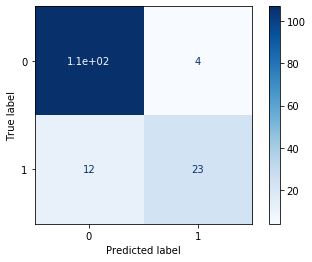

In [267]:
plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.show()

In [268]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

In [269]:
auc_score = auc(fpr, tpr)

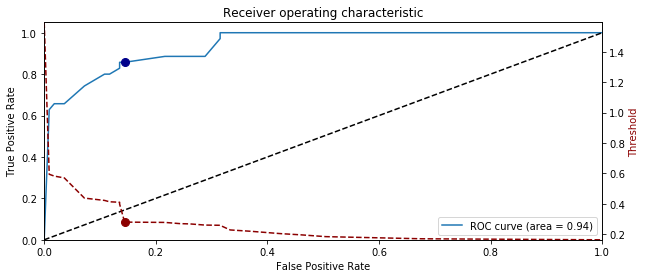

 -- Optimum Threshold -- 
        fpr       tpr     1-fpr        tf  thresholds
9  0.144144  0.857143  0.855856  0.001287    0.279278


In [270]:
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

# find optimum thresholds
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i).apply(lambda x: abs(x)), 'thresholds' : pd.Series(thresholds, index = i)})
df_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

plt.plot(df_thresh['fpr'], df_thresh['tpr'], marker='o', markersize=8, color='darkblue')

# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='darkred')
ax2.set_ylabel('Threshold',color='darkred')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])
ax2.plot(df_thresh['fpr'], df_thresh['thresholds'], marker='o', markersize=8, color='darkred')


plt.show()
print(" -- Optimum Threshold -- ")
print(df_thresh)

## Bootstrapped

In [271]:
accuracy_list = []
auc_list = []
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    clf = model_choice
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
    auc_score = auc(fpr, tpr)
    
    accuracy_list.append(accuracy)
    auc_list.append(auc_score)
    print("Iteration %s: AUC:%s, Accuracy:%s" % (i, auc_score, accuracy))

Iteration 0: AUC:0.944396551724138, Accuracy:0.8698630136986302
Iteration 1: AUC:0.91005291005291, Accuracy:0.9178082191780822
Iteration 2: AUC:0.9061711079943898, Accuracy:0.8561643835616438
Iteration 3: AUC:0.9086523498288204, Accuracy:0.8904109589041096
Iteration 4: AUC:0.9453525641025641, Accuracy:0.8904109589041096
Iteration 5: AUC:0.921455938697318, Accuracy:0.910958904109589
Iteration 6: AUC:0.9159663865546219, Accuracy:0.8835616438356164
Iteration 7: AUC:0.8944627192982456, Accuracy:0.8835616438356164
Iteration 8: AUC:0.9073849878934626, Accuracy:0.8904109589041096
Iteration 9: AUC:0.8869731800766284, Accuracy:0.8835616438356164
Iteration 10: AUC:0.8983471074380165, Accuracy:0.910958904109589
Iteration 11: AUC:0.8985632183908047, Accuracy:0.8698630136986302
Iteration 12: AUC:0.9158485273492286, Accuracy:0.9041095890410958
Iteration 13: AUC:0.9270114942528735, Accuracy:0.8904109589041096
Iteration 14: AUC:0.9304450338933098, Accuracy:0.9246575342465754
Iteration 15: AUC:0.892554

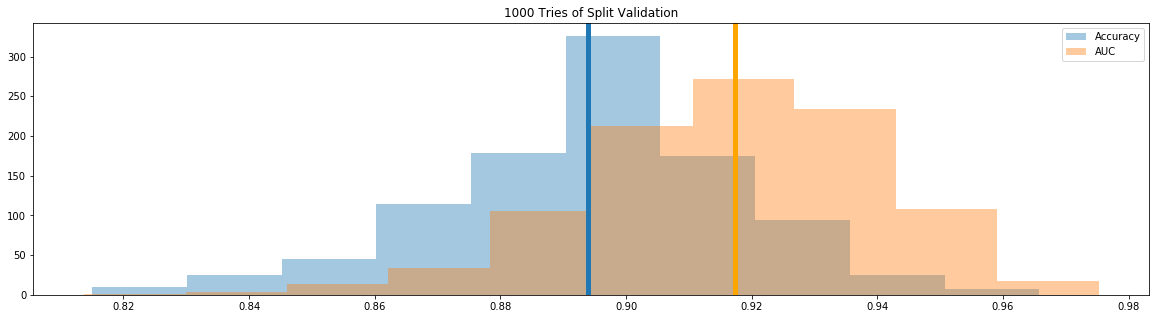

Accuracy mean: 0.89
AUC mean: 0.92


In [272]:
plt.figure(figsize=(20,5))
plt.title("1000 Tries of Split Validation")
sns.distplot(accuracy_list, bins=10, label = 'Accuracy', kde=False)
sns.distplot(auc_list, bins=10, label = 'AUC', kde=False)
plt.axvline(x=pd.Series(accuracy_list).mean(), lw=5)
plt.axvline(x=pd.Series(auc_list).mean(), lw=5, color='orange')
plt.legend()
plt.show()
print("Accuracy mean: %0.2f" % pd.Series(accuracy_list).mean())
print("AUC mean: %0.2f" % pd.Series(auc_list).mean())

## Model Comparison

In [273]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [274]:
## Initiate models
models = []
models.append(('K-Nearest Neighbour', KNeighborsClassifier()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier()))
models.append(('Gaussian Naive Bayes', GaussianNB()))
models.append(('XGBoost Classifier', XGBClassifier(**params)))

In [275]:
## Results
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    ## AUC Scoring
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    print('%s: \nAUC Mean %f, STD %f'%(name, cv_results.mean(), cv_results.std()))

K-Nearest Neighbour: 
AUC Mean 0.799592, STD 0.087965
Decision Tree Classifier: 
AUC Mean 0.855918, STD 0.096558
Gaussian Naive Bayes: 
AUC Mean 0.907959, STD 0.041652
XGBoost Classifier: 
AUC Mean 0.906327, STD 0.032821


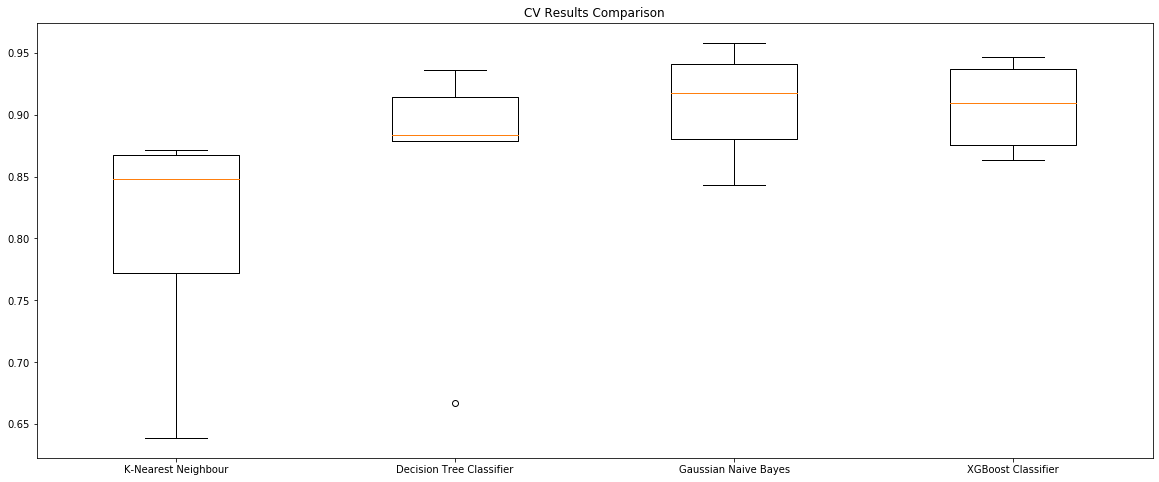

In [276]:
## Results Distribution
plt.figure(figsize=(20,8))
plt.boxplot(results, labels=names)
plt.title('CV Results Comparison')
plt.show()

## Dump To Pickle

In [277]:
clf = model_choice
clf = clf.fit(X, y)
# pickle.dump(clf, open('../models/final_prediction.pickle', 'wb'))

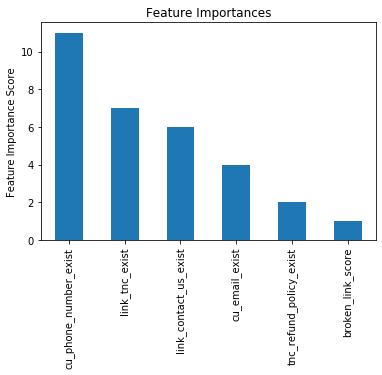

In [278]:
feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()